Load the Data

Clean In & Out Time Data
Since in_time.csv and out_time.csv contain timestamps, 

we need to: 

1.Drop columns where all values are NaN

2.Convert timestamps to datetime format

3.Compute worked hours for each day

4.Calculate the average daily worked hours per employee


In [65]:
import pandas as pd
import os

downloads_dir = r"C:\Cesi\cesi 2eme année\ia block"
in_out_time_dir = r"C:\Cesi\cesi 2eme année\ia block\in_out_time"

# Load files from the Downloads directory
general_data = pd.read_csv(os.path.join(downloads_dir, "general_data.csv"))
manager_survey = pd.read_csv(os.path.join(downloads_dir, "manager_survey_data.csv"))
employee_survey = pd.read_csv(os.path.join(downloads_dir, "employee_survey_data.csv"))

# Load files from the in_out_time directory
in_time = pd.read_csv(os.path.join(in_out_time_dir, "in_time.csv"))
out_time = pd.read_csv(os.path.join(in_out_time_dir, "out_time.csv"))


In [66]:
for name, df in {
    "general_data": general_data,
    "manager_survey": manager_survey,
    "employee_survey": employee_survey,
    "in_time": in_time,
    "out_time": out_time
}.items():
    print(f"{name}: {df.shape[0]} rows, {df.shape[1]} columns")

general_data: 4410 rows, 24 columns
manager_survey: 4410 rows, 3 columns
employee_survey: 4410 rows, 4 columns
in_time: 4410 rows, 262 columns
out_time: 4410 rows, 262 columns


 We then proceed to delete/ remove the NAN values from the data set

In [67]:

# Drop columns where all values are NaN
in_time.dropna(axis=1, how="all", inplace=True)
out_time.dropna(axis=1, how="all", inplace=True)

print(f"After dropping all-NaN columns, in_time shape: {in_time.shape}")
print(f"After dropping all-NaN columns, out_time shape: {out_time.shape}")


#print the first few rows to see the effect
print("\nFirst few rows of after dropping all-NaN columns:")
print(in_time.head(3))
#print(out_time.head(3)) 


After dropping all-NaN columns, in_time shape: (4410, 250)
After dropping all-NaN columns, out_time shape: (4410, 250)

First few rows of after dropping all-NaN columns:
   Unnamed: 0           2015-01-02           2015-01-05           2015-01-06  \
0           1  2015-01-02 09:43:45  2015-01-05 10:08:48  2015-01-06 09:54:26   
1           2  2015-01-02 10:15:44  2015-01-05 10:21:05                  NaN   
2           3  2015-01-02 10:17:41  2015-01-05 09:50:50  2015-01-06 10:14:13   

            2015-01-07           2015-01-08           2015-01-09  \
0  2015-01-07 09:34:31  2015-01-08 09:51:09  2015-01-09 10:09:25   
1  2015-01-07 09:45:17  2015-01-08 10:09:04  2015-01-09 09:43:26   
2  2015-01-07 09:47:27  2015-01-08 10:03:40  2015-01-09 10:05:49   

            2015-01-12           2015-01-13           2015-01-15  ...  \
0  2015-01-12 09:42:53  2015-01-13 10:13:06  2015-01-15 10:01:24  ...   
1  2015-01-12 10:00:07  2015-01-13 10:43:29  2015-01-15 09:37:57  ...   
2  2015-01-12 10:

we now have to convert the data to a datetime format in the other columns and rows except for the Employee ID



















In [68]:
# Convert to datetime format (skip Employee ID column)
for col in in_time.columns[1:]:
    in_time[col] = pd.to_datetime(in_time[col], errors='coerce')
    out_time[col] = pd.to_datetime(out_time[col], errors='coerce')

# Print verification
print("\n=== Data Types After Conversion ===")
print("in_time dtypes:")
print(in_time.dtypes.head())  # Show first few columns
print("\nout_time dtypes:")
print(out_time.dtypes.head())


=== Data Types After Conversion ===
in_time dtypes:
Unnamed: 0             int64
2015-01-02    datetime64[ns]
2015-01-05    datetime64[ns]
2015-01-06    datetime64[ns]
2015-01-07    datetime64[ns]
dtype: object

out_time dtypes:
Unnamed: 0             int64
2015-01-02    datetime64[ns]
2015-01-05    datetime64[ns]
2015-01-06    datetime64[ns]
2015-01-07    datetime64[ns]
dtype: object


In [69]:
# Calculate worked hours per day
worked_hours = (out_time.iloc[:, 1:] - in_time.iloc[:, 1:]).apply(lambda x: x.dt.total_seconds() / 3600)

# Add a column for the mean working hours
worked_hours["mean_work_hours"] = worked_hours.mean(axis=1)

# Insert Employee ID back
worked_hours.insert(0, "EmployeeID", in_time.iloc[:, 0])

# Keep only EmployeeID and mean_work_hours
worked_hours = worked_hours[["EmployeeID", "mean_work_hours"]]

# Check the result
print("\n=== Final DataFrame ===")
print(worked_hours.head())

# Print the output
print("\n=== Worked Hours Per Day (First 5 Rows) ===")
print(worked_hours.head())

print("\n=== Summary Statistics ===")
print(worked_hours.describe())


=== Final DataFrame ===
   EmployeeID  mean_work_hours
0           1         7.373651
1           2         7.718969
2           3         7.013240
3           4         7.193678
4           5         8.006175

=== Worked Hours Per Day (First 5 Rows) ===
   EmployeeID  mean_work_hours
0           1         7.373651
1           2         7.718969
2           3         7.013240
3           4         7.193678
4           5         8.006175

=== Summary Statistics ===
        EmployeeID  mean_work_hours
count  4410.000000      4410.000000
mean   2205.500000         7.700792
std    1273.201673         1.340218
min       1.000000         5.950504
25%    1103.250000         6.673333
50%    2205.500000         7.406761
75%    3307.750000         8.368703
max    4410.000000        11.030960


Merge All Data: merge the datasets using EmployeeID as the common key.

In [70]:
# Merge datasets

final_data = general_data.merge(manager_survey, on="EmployeeID", how="left")
final_data = final_data.merge(employee_survey, on="EmployeeID", how="left")
final_data = final_data.merge(worked_hours, on="EmployeeID", how="left")

# Check the final dataset
print(final_data.head())

final_data.to_csv("final_data_preview.csv", index=False)


   Age Attrition     BusinessTravel              Department  DistanceFromHome  \
0   51        No      Travel_Rarely                   Sales                 6   
1   31       Yes  Travel_Frequently  Research & Development                10   
2   32        No  Travel_Frequently  Research & Development                17   
3   38        No         Non-Travel  Research & Development                 2   
4   32        No      Travel_Rarely  Research & Development                10   

   Education EducationField  EmployeeCount  EmployeeID  Gender  ...  \
0          2  Life Sciences              1           1  Female  ...   
1          1  Life Sciences              1           2  Female  ...   
2          4          Other              1           3    Male  ...   
3          5  Life Sciences              1           4    Male  ...   
4          1        Medical              1           5    Male  ...   

   TrainingTimesLastYear YearsAtCompany YearsSinceLastPromotion  \
0                  

#Now we can proceed and handle the missing values in the merged data set

so the first step includes checking the missing values in the data set.

In [71]:
print(final_data.isnull().sum().sort_values(ascending=False))
#use knn

WorkLifeBalance            38
EnvironmentSatisfaction    25
JobSatisfaction            20
NumCompaniesWorked         19
TotalWorkingYears           9
Age                         0
PercentSalaryHike           0
PerformanceRating           0
JobInvolvement              0
YearsWithCurrManager        0
YearsSinceLastPromotion     0
YearsAtCompany              0
TrainingTimesLastYear       0
StockOptionLevel            0
StandardHours               0
Over18                      0
Attrition                   0
MonthlyIncome               0
MaritalStatus               0
JobRole                     0
JobLevel                    0
Gender                      0
EmployeeID                  0
EmployeeCount               0
EducationField              0
Education                   0
DistanceFromHome            0
Department                  0
BusinessTravel              0
mean_work_hours             0
dtype: int64


In [72]:
final_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,mean_work_hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,6,1,0,0,3,3,3.0,4.0,2.0,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,3,5,1,4,2,4,3.0,2.0,4.0,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,2,5,0,3,3,3,2.0,2.0,1.0,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,5,8,7,5,2,3,4.0,4.0,3.0,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,2,6,0,4,3,3,4.0,1.0,3.0,8.006175


In [73]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   EmployeeID               4410 non-null   int64  
 9   Gender                   4410 non-null   object 
 10  JobLevel                 4410 non-null   int64  
 11  JobRole                  4410 non-null   object 
 12  MaritalStatus            4410 non-null   object 
 13  MonthlyIncome            4410 non-null   int64  
 14  NumCompaniesWorked      

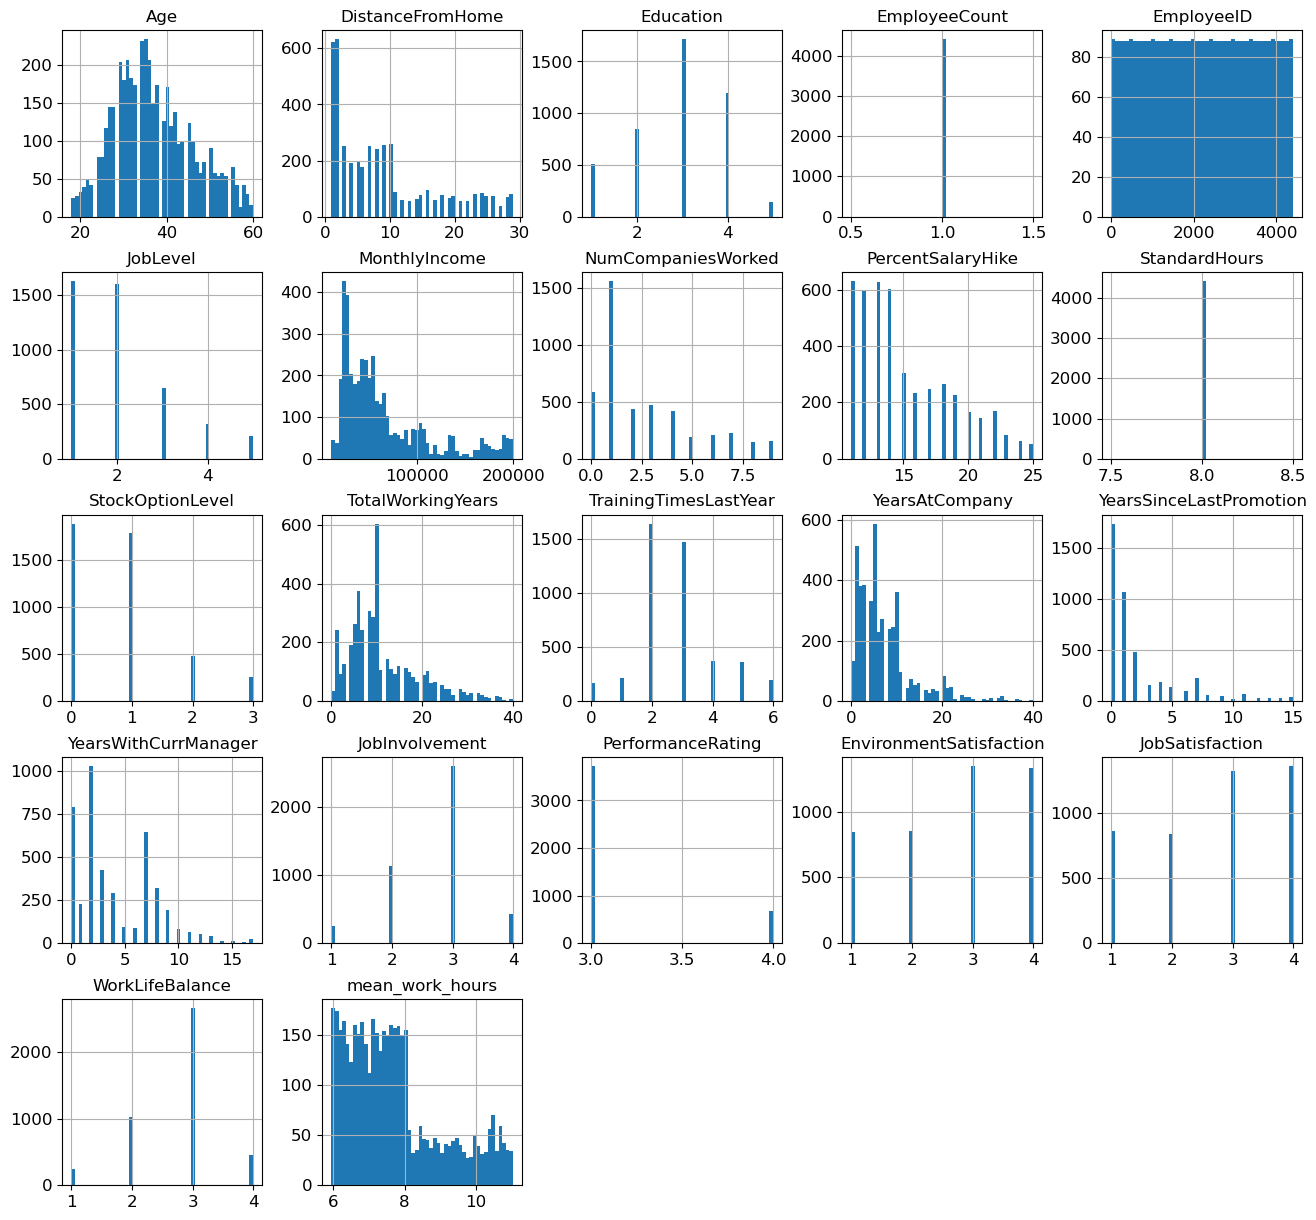

In [74]:
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14 
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

final_data.hist(bins=50,figsize=(16,15))
plt.show()

In [75]:
final_data["WorkLifeBalance"].value_counts()

WorkLifeBalance
3.0    2660
2.0    1019
4.0     454
1.0     239
Name: count, dtype: int64

In [76]:
#
from sklearn.impute import KNNImputer

# Instancier KNN Imputer
knn_imputer = KNNImputer(n_neighbors=5)

for col in ['WorkLifeBalance', 'EnvironmentSatisfaction', 'JobSatisfaction']:
    final_data[col].fillna(final_data[col].mode()[0], inplace=True)

# Appliquer l'imputation sur tout le DataFrame
numeric_columns_with_missing_values = ['NumCompaniesWorked', 'TotalWorkingYears']
final_data[numeric_columns_with_missing_values] = knn_imputer.fit_transform(final_data[numeric_columns_with_missing_values])

C:\Users\sixel\AppData\Local\Temp\ipykernel_36160\3622631526.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  final_data[col].fillna(final_data[col].mode()[0], inplace=True)


In [77]:
print(final_data.isnull().sum().sort_values(ascending=False))

Age                        0
Attrition                  0
WorkLifeBalance            0
JobSatisfaction            0
EnvironmentSatisfaction    0
PerformanceRating          0
JobInvolvement             0
YearsWithCurrManager       0
YearsSinceLastPromotion    0
YearsAtCompany             0
TrainingTimesLastYear      0
TotalWorkingYears          0
StockOptionLevel           0
StandardHours              0
PercentSalaryHike          0
Over18                     0
NumCompaniesWorked         0
MonthlyIncome              0
MaritalStatus              0
JobRole                    0
JobLevel                   0
Gender                     0
EmployeeID                 0
EmployeeCount              0
EducationField             0
Education                  0
DistanceFromHome           0
Department                 0
BusinessTravel             0
mean_work_hours            0
dtype: int64


In [78]:
numeric_columns = ['NumCompaniesWorked', 'TotalWorkingYears','Age']

In [79]:
final_Numeric_data = final_data.copy() # A new copy of data set 
final_Numeric_data.drop("EmployeeCount", axis=1, inplace=True) # Not numerical 
final_Numeric_data.drop("EmployeeID", axis=1, inplace=True) # Not numerical 
final_Numeric_data.drop("StandardHours", axis=1, inplace=True) # Not numerical
final_Numeric_data.drop("JobInvolvement", axis=1, inplace=True) # Not numerical
final_Numeric_data.drop("PerformanceRating", axis=1, inplace=True) # Not numerical
final_Numeric_data.drop("EnvironmentSatisfaction", axis=1, inplace=True) # Not numerical
final_Numeric_data.drop("JobSatisfaction", axis=1, inplace=True) # Not numerical
final_Numeric_data.drop("WorkLifeBalance", axis=1, inplace=True) # Not numerical
final_Numeric_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,NumCompaniesWorked,Over18,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,mean_work_hours
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,Y,11,0,1.0,6,1,0,0,7.373651
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,0.0,Y,23,1,6.0,3,5,1,4,7.718969
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,1.0,Y,15,3,5.0,2,5,0,3,7.013240
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,3.0,Y,11,3,13.0,5,8,7,5,7.193678
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,4.0,Y,12,2,9.0,2,6,0,4,8.006175


In [80]:
import numpy as np

# Étape 1 : Filtrer les colonnes numériques seulement
numeric_data = final_Numeric_data.select_dtypes(include=[np.number])

# Étape 2 : Calculer la matrice de corrélation
correlation_matrix = numeric_data.corr()


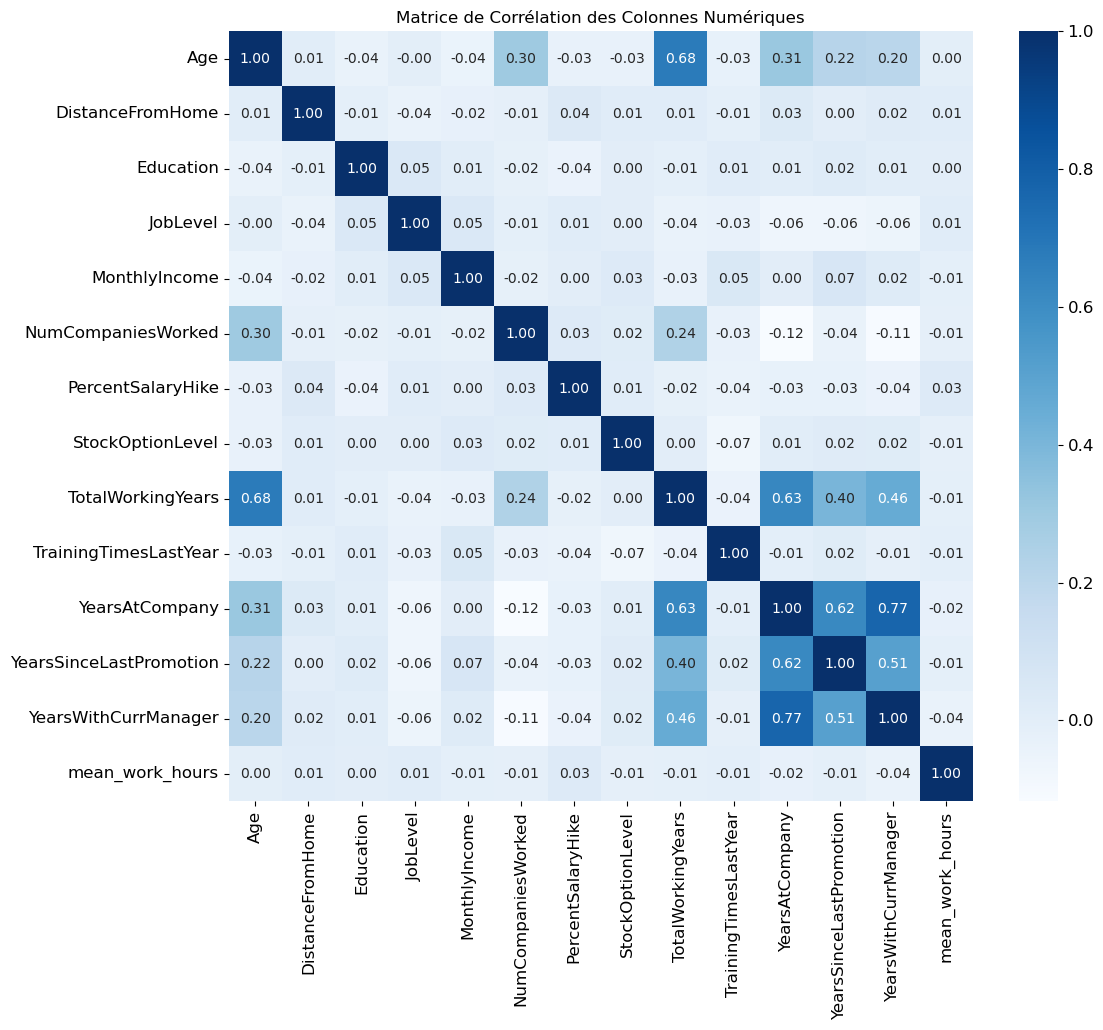

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt



plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", fmt=".2f")
plt.title("Matrice de Corrélation des Colonnes Numériques")
plt.show()

In [82]:

# Étape 3 : Identifier les paires avec des corrélations supérieures au seuil
threshold = 0.7  # Par exemple, 0.9 (modifier si nécessaire)
upper_triangle = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)

# Récupérer uniquement la partie supérieure pour éviter les doublons
upper_corr_matrix = correlation_matrix.where(upper_triangle)

# Colonnes ayant une corrélation élevée
drop_columns = [column for column in upper_corr_matrix.columns if any(upper_corr_matrix[column] > threshold)]

print("\n=== Colonnes à Supprimer ===")
print(drop_columns)


=== Colonnes à Supprimer ===
['YearsWithCurrManager']


In [83]:
# Étape 4 : Retirer les colonnes sélectionnées du dataframe final
final_data = final_data.drop(columns=drop_columns)

# Vérification
print("\n=== Final Data Shape ===")
print(final_data.shape)


=== Final Data Shape ===
(4410, 29)
